# 📚 Week 10: Recurrent Neural Networks & Sequence Models

## Mastering Temporal Dependencies in Financial Markets

**Learning Objectives:**
- Understand why sequential data requires specialized architectures
- Master RNN, LSTM, and GRU fundamentals
- Implement attention mechanisms for financial forecasting
- Build production-ready sequence models for trading

---

### Week Overview

| Day | Topic | Key Concepts |
|-----|-------|-------------|
| 1 | RNN Fundamentals | Recurrence, hidden states, BPTT |
| 2 | Vanishing Gradients | Problem analysis, solutions |
| 3 | LSTM Networks | Gates, cell state, memory |
| 4 | GRU Networks | Simplified gating, efficiency |
| 5 | Bidirectional & Stacked | Multi-layer architectures |
| 6 | Attention Mechanisms | Self-attention, transformers intro |
| 7 | Complete Sequence Model | End-to-end trading system |

In [1]:
# ============================================================
# WEEK 10: RNN & SEQUENCE MODELS - THEORY NOTEBOOK
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Libraries loaded! Device: {device}")
print(f"📚 Week 10: Recurrent Neural Networks & Sequence Models")

✅ Libraries loaded! Device: cpu
📚 Week 10: Recurrent Neural Networks & Sequence Models


---

## Part 1: Why Sequence Models for Finance?

### The Problem with Standard MLPs

Financial time series have **temporal dependencies**:
- Today's price depends on yesterday's patterns
- Volatility clusters persist over time
- Market regimes evolve gradually

**MLPs treat each input independently** - they can't learn:
- Order matters (sequence position)
- Variable-length inputs
- Long-term dependencies

### The Recurrence Principle

$$h_t = f(h_{t-1}, x_t)$$

Where:
- $h_t$ = hidden state at time $t$ (memory)
- $x_t$ = input at time $t$
- $f$ = learned transition function

TEMPORAL DEPENDENCIES IN FINANCIAL DATA

Autocorrelation Analysis (evidence of temporal dependency):
------------------------------------------------------------
  Lag  1:  0.1694 ***
  Lag  2:  0.0561 **
  Lag  5: -0.0450 *
  Lag 10:  0.0307 *
  Lag 20:  0.0171 

*** = strong dependency, ** = moderate, * = weak


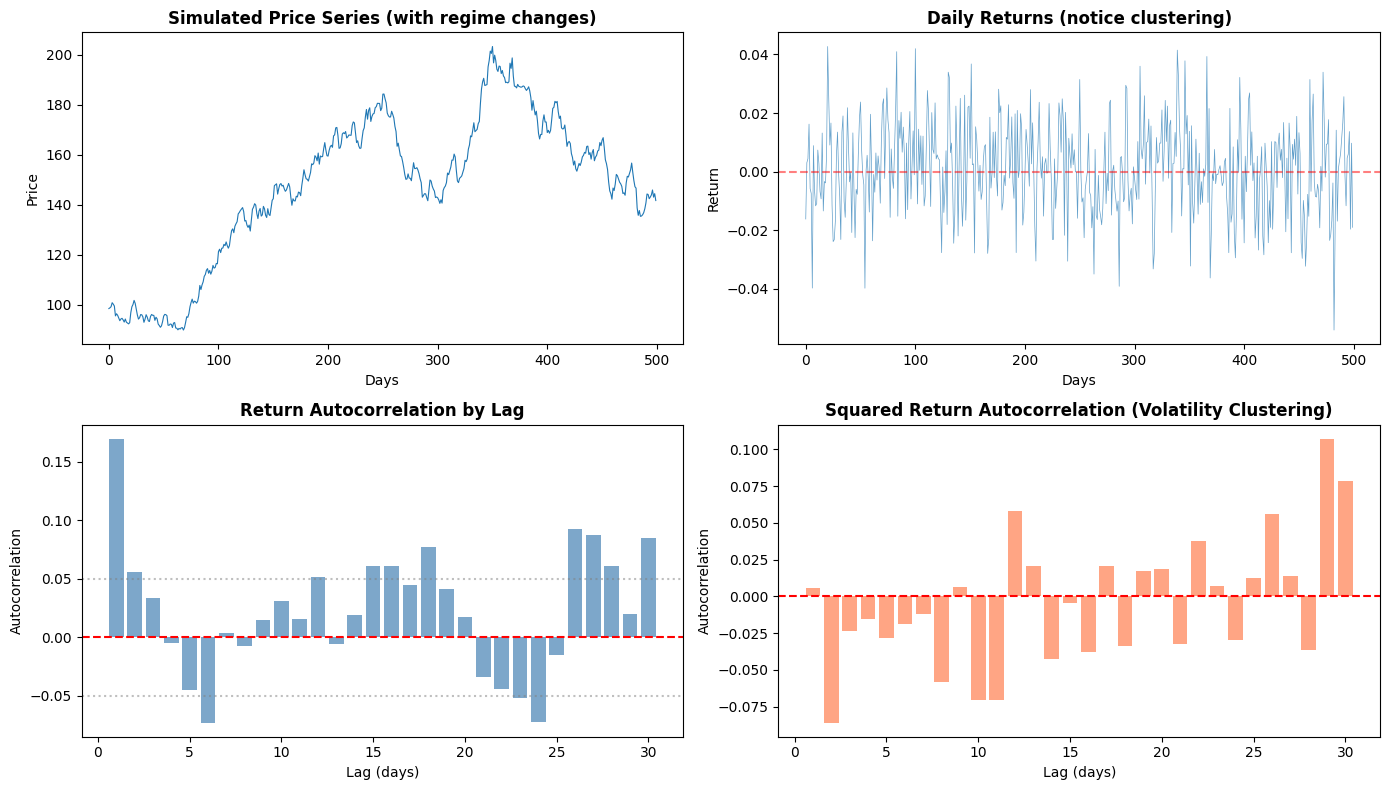


💡 KEY INSIGHT: Squared returns show strong autocorrelation
   → Volatility clusters (high vol follows high vol)
   → This is why sequence models are essential for risk modeling!


In [2]:
# ============================================================
# DEMONSTRATING TEMPORAL DEPENDENCIES IN FINANCE
# ============================================================

print("TEMPORAL DEPENDENCIES IN FINANCIAL DATA")
print("="*60)

# Generate synthetic price data with momentum + mean reversion
n_days = 500
np.random.seed(42)

# Simulate a trending market with regime changes
returns = []
regime = 'bull'  # Start in bull market
momentum = 0.0

for i in range(n_days):
    # Regime switching probability
    if np.random.random() < 0.02:  # 2% chance of regime change
        regime = 'bear' if regime == 'bull' else 'bull'
    
    # Regime-dependent drift
    drift = 0.0005 if regime == 'bull' else -0.0003
    
    # Momentum factor (depends on past returns)
    momentum = 0.3 * momentum + 0.7 * (returns[-1] if returns else 0)
    
    # Generate return
    ret = drift + 0.2 * momentum + np.random.normal(0, 0.015)
    returns.append(ret)

returns = np.array(returns)
prices = 100 * np.cumprod(1 + returns)

# Calculate autocorrelation - proof of temporal dependency
def autocorrelation(x, lag):
    n = len(x)
    mean = np.mean(x)
    var = np.var(x)
    return np.sum((x[:-lag] - mean) * (x[lag:] - mean)) / ((n - lag) * var)

print("\nAutocorrelation Analysis (evidence of temporal dependency):")
print("-" * 60)
for lag in [1, 2, 5, 10, 20]:
    ac = autocorrelation(returns, lag)
    significance = "***" if abs(ac) > 0.1 else "**" if abs(ac) > 0.05 else "*" if abs(ac) > 0.02 else ""
    print(f"  Lag {lag:2d}: {ac:7.4f} {significance}")

print("\n*** = strong dependency, ** = moderate, * = weak")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Price series
axes[0, 0].plot(prices, linewidth=0.8)
axes[0, 0].set_title('Simulated Price Series (with regime changes)', fontweight='bold')
axes[0, 0].set_xlabel('Days')
axes[0, 0].set_ylabel('Price')

# Returns
axes[0, 1].plot(returns, linewidth=0.5, alpha=0.7)
axes[0, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Daily Returns (notice clustering)', fontweight='bold')
axes[0, 1].set_xlabel('Days')
axes[0, 1].set_ylabel('Return')

# Autocorrelation
lags = range(1, 31)
autocorrs = [autocorrelation(returns, l) for l in lags]
axes[1, 0].bar(lags, autocorrs, color='steelblue', alpha=0.7)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].axhline(0.05, color='gray', linestyle=':', alpha=0.5)
axes[1, 0].axhline(-0.05, color='gray', linestyle=':', alpha=0.5)
axes[1, 0].set_title('Return Autocorrelation by Lag', fontweight='bold')
axes[1, 0].set_xlabel('Lag (days)')
axes[1, 0].set_ylabel('Autocorrelation')

# Squared returns (volatility clustering)
sq_autocorrs = [autocorrelation(returns**2, l) for l in lags]
axes[1, 1].bar(lags, sq_autocorrs, color='coral', alpha=0.7)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title('Squared Return Autocorrelation (Volatility Clustering)', fontweight='bold')
axes[1, 1].set_xlabel('Lag (days)')
axes[1, 1].set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT: Squared returns show strong autocorrelation")
print("   → Volatility clusters (high vol follows high vol)")
print("   → This is why sequence models are essential for risk modeling!")

---

## Part 2: Vanilla RNN Architecture

### Mathematical Formulation

At each timestep $t$:

$$h_t = \tanh(W_{hh} \cdot h_{t-1} + W_{xh} \cdot x_t + b_h)$$
$$y_t = W_{hy} \cdot h_t + b_y$$

Where:
- $W_{hh}$ = hidden-to-hidden weights (recurrence)
- $W_{xh}$ = input-to-hidden weights
- $W_{hy}$ = hidden-to-output weights
- $h_t$ = hidden state (memory)

### Weight Sharing

**Same weights used at every timestep** - this is key!
- Enables variable-length sequences
- Learns temporal patterns independent of position
- Far fewer parameters than fully connected

In [3]:
# ============================================================
# VANILLA RNN FROM SCRATCH
# ============================================================

print("VANILLA RNN IMPLEMENTATION")
print("="*60)

class VanillaRNN(nn.Module):
    """Simple RNN for understanding the fundamentals."""
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        
        # Learnable parameters
        self.W_xh = nn.Linear(input_size, hidden_size, bias=False)   # Input to hidden
        self.W_hh = nn.Linear(hidden_size, hidden_size, bias=True)   # Hidden to hidden
        self.W_hy = nn.Linear(hidden_size, output_size)              # Hidden to output
        
    def forward(self, x, h_prev=None):
        """
        x: (batch, seq_len, input_size)
        Returns: output (batch, output_size), final hidden state
        """
        batch_size, seq_len, _ = x.shape
        
        # Initialize hidden state
        if h_prev is None:
            h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        else:
            h = h_prev
        
        # Process sequence step by step
        hidden_states = []
        for t in range(seq_len):
            x_t = x[:, t, :]  # Input at timestep t
            
            # RNN equation: h_t = tanh(W_xh * x_t + W_hh * h_{t-1} + b)
            h = torch.tanh(self.W_xh(x_t) + self.W_hh(h))
            hidden_states.append(h)
        
        # Output from final hidden state
        output = self.W_hy(h)
        
        return output, h, hidden_states

# Test the implementation
input_size = 5   # e.g., 5 features per timestep
hidden_size = 20
output_size = 1  # Predict next return
seq_len = 10     # Look at 10 days of history
batch_size = 4

rnn = VanillaRNN(input_size, hidden_size, output_size)

# Create sample input
x = torch.randn(batch_size, seq_len, input_size)

# Forward pass
output, final_h, all_h = rnn(x)

print(f"\nArchitecture:")
print(f"  Input size:  {input_size} features per timestep")
print(f"  Hidden size: {hidden_size} units")
print(f"  Output size: {output_size}")
print(f"  Sequence length: {seq_len} timesteps")

print(f"\nTensor Shapes:")
print(f"  Input:         {x.shape}")
print(f"  Output:        {output.shape}")
print(f"  Final hidden:  {final_h.shape}")

# Count parameters
total_params = sum(p.numel() for p in rnn.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Compare to MLP that would take flattened input
mlp_params = (seq_len * input_size) * hidden_size + hidden_size * output_size
print(f"Equivalent MLP params (single layer): {mlp_params:,}")
print(f"\n✅ RNN uses same weights for ALL timesteps → far fewer parameters!")

VANILLA RNN IMPLEMENTATION

Architecture:
  Input size:  5 features per timestep
  Hidden size: 20 units
  Output size: 1
  Sequence length: 10 timesteps

Tensor Shapes:
  Input:         torch.Size([4, 10, 5])
  Output:        torch.Size([4, 1])
  Final hidden:  torch.Size([4, 20])

Total parameters: 541
Equivalent MLP params (single layer): 1,020

✅ RNN uses same weights for ALL timesteps → far fewer parameters!


---

## Part 3: The Vanishing Gradient Problem

### Why Vanilla RNNs Fail on Long Sequences

During backpropagation through time (BPTT):

$$\frac{\partial L}{\partial h_0} = \frac{\partial L}{\partial h_T} \cdot \prod_{t=1}^{T} \frac{\partial h_t}{\partial h_{t-1}}$$

Each term: $\frac{\partial h_t}{\partial h_{t-1}} = W_{hh}^T \cdot \text{diag}(1 - h_t^2)$

**Problem:** If $|W_{hh}| < 1$, gradients shrink exponentially!
- After 100 steps: $0.9^{100} \approx 0.00003$
- Gradients vanish → can't learn long-term dependencies

**Financial Impact:**
- Can't learn quarterly earnings patterns (60+ trading days)
- Can't capture year-over-year seasonality
- Struggles with regime changes

VANISHING GRADIENT DEMONSTRATION


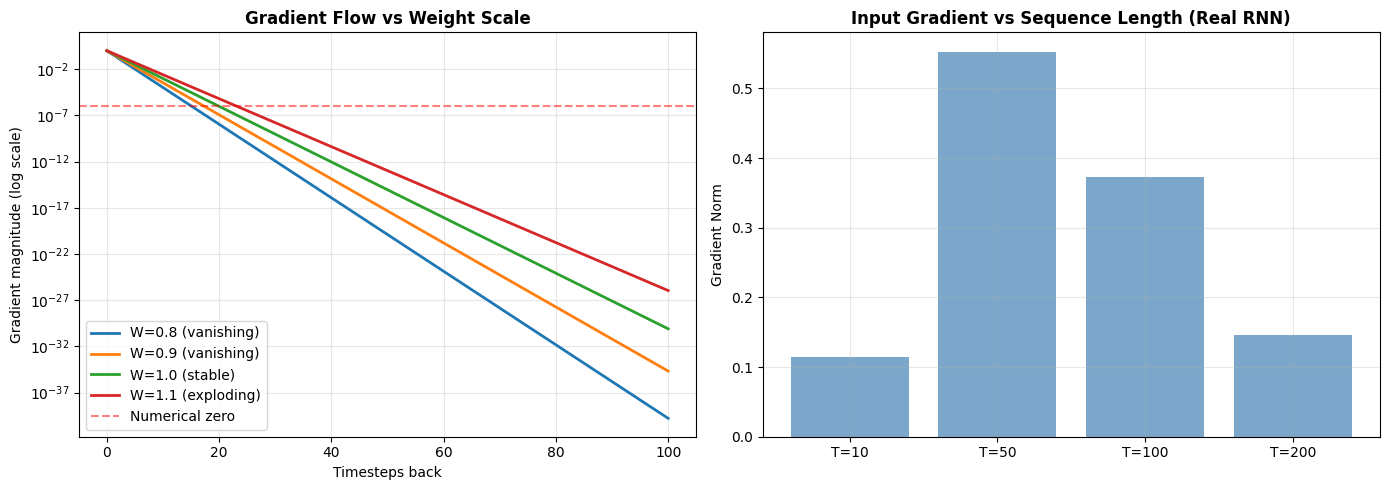


💡 KEY INSIGHT:
   - Gradients vanish exponentially with sequence length
   - Long-term dependencies become unlearnable
   - Solution: LSTM/GRU with gating mechanisms


In [4]:
# ============================================================
# VISUALIZING VANISHING GRADIENTS
# ============================================================

print("VANISHING GRADIENT DEMONSTRATION")
print("="*60)

def compute_gradient_flow(seq_length, weight_scale=0.9):
    """Simulate gradient flow through RNN."""
    gradient = 1.0
    gradients = [gradient]
    
    for t in range(seq_length):
        # Simplified: gradient *= W_hh * tanh'(h)
        # tanh' ∈ [0, 1], average ~0.5
        gradient *= weight_scale * 0.5
        gradients.append(gradient)
    
    return np.array(gradients)

# Compare different weight scales
seq_lengths = [50, 100, 200]
weight_scales = [0.8, 0.9, 1.0, 1.1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Different weight scales
for ws in weight_scales:
    grads = compute_gradient_flow(100, ws)
    label = f'W={ws}' + (' (vanishing)' if ws < 1 else ' (exploding)' if ws > 1 else ' (stable)')
    axes[0].semilogy(grads, label=label, linewidth=2)

axes[0].axhline(1e-6, color='red', linestyle='--', alpha=0.5, label='Numerical zero')
axes[0].set_xlabel('Timesteps back')
axes[0].set_ylabel('Gradient magnitude (log scale)')
axes[0].set_title('Gradient Flow vs Weight Scale', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Real RNN gradient norms
class GradientTracker(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])

# Track gradients for different sequence lengths
gradient_norms = {}

for seq_len in [10, 50, 100, 200]:
    model = GradientTracker(5, 32)
    x = torch.randn(1, seq_len, 5, requires_grad=True)
    y = torch.randn(1, 1)
    
    output = model(x)
    loss = (output - y).pow(2).mean()
    loss.backward()
    
    # Get gradient w.r.t. input
    gradient_norms[seq_len] = x.grad.norm().item()

axes[1].bar(range(len(gradient_norms)), list(gradient_norms.values()), 
            tick_label=[f'T={k}' for k in gradient_norms.keys()],
            color='steelblue', alpha=0.7)
axes[1].set_ylabel('Gradient Norm')
axes[1].set_title('Input Gradient vs Sequence Length (Real RNN)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT:")
print("   - Gradients vanish exponentially with sequence length")
print("   - Long-term dependencies become unlearnable")
print("   - Solution: LSTM/GRU with gating mechanisms")

---

## Part 4: Long Short-Term Memory (LSTM)

### The Gating Solution

LSTM introduces **gates** to control information flow:

**1. Forget Gate** - What to discard from memory:
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

**2. Input Gate** - What new information to store:
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**3. Cell State Update** - The memory:
$$C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$$

**4. Output Gate** - What to output:
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$
$$h_t = o_t \odot \tanh(C_t)$$

### Why This Solves Vanishing Gradients

The cell state $C_t$ has an **additive update**:
$$C_t = f_t \odot C_{t-1} + ...$$

Gradient flows through multiplication by $f_t$ (close to 1), not through repeated matrix multiplications!

LSTM ARCHITECTURE

LSTM Architecture:
  Input:  torch.Size([1, 20, 5])
  Output: torch.Size([1, 1])


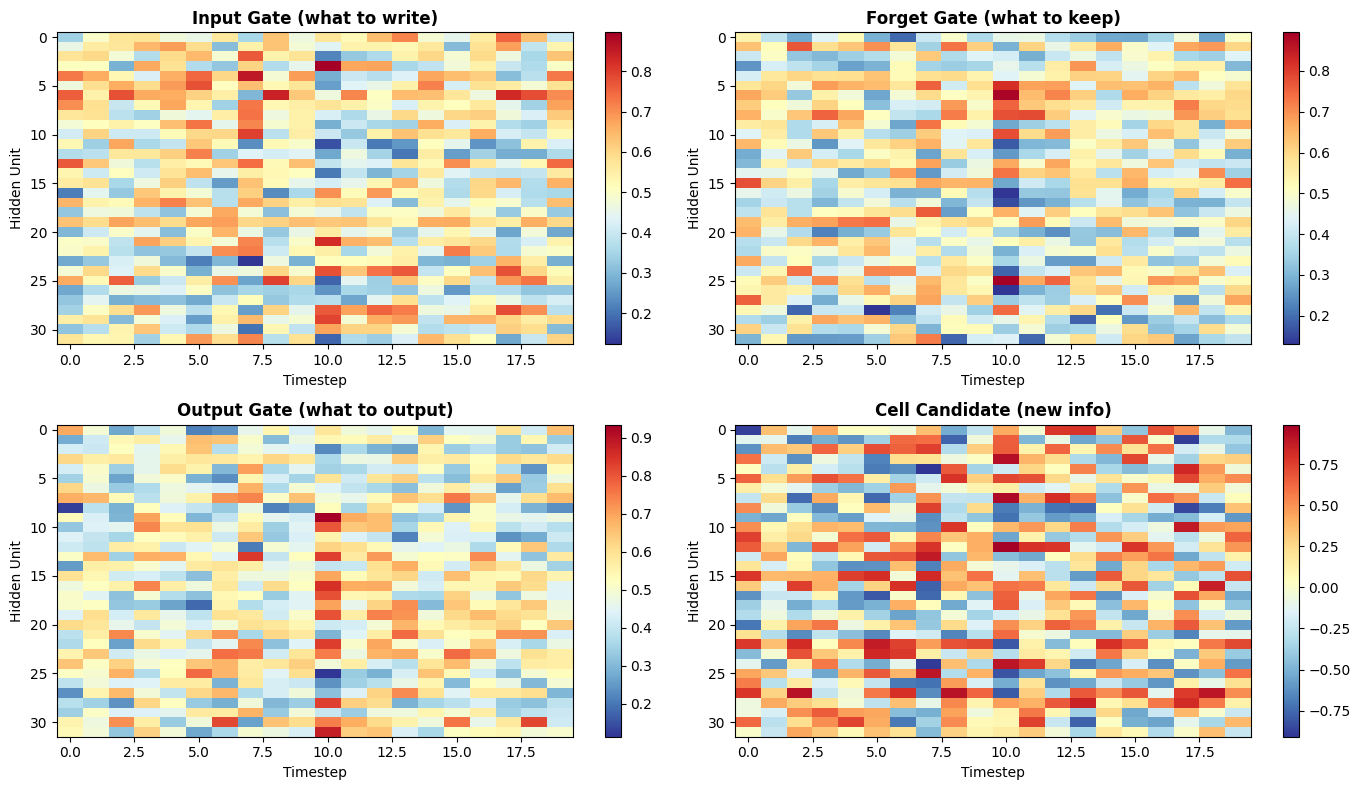


💡 KEY INSIGHTS:
   - Forget gate near 1 → preserve memory (good for long dependencies)
   - Input gate controls what new info enters
   - Output gate filters what hidden state to expose


In [5]:
# ============================================================
# LSTM FROM SCRATCH (FOR UNDERSTANDING)
# ============================================================

print("LSTM ARCHITECTURE")
print("="*60)

class LSTMCell(nn.Module):
    """Single LSTM cell for educational purposes."""
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Combined weights for efficiency (input, forget, cell, output)
        self.W_x = nn.Linear(input_size, 4 * hidden_size)  # Input contribution
        self.W_h = nn.Linear(hidden_size, 4 * hidden_size) # Hidden contribution
        
    def forward(self, x, h_prev, c_prev):
        """
        x: (batch, input_size)
        h_prev: (batch, hidden_size)
        c_prev: (batch, hidden_size) - cell state
        """
        # Compute all gates at once
        gates = self.W_x(x) + self.W_h(h_prev)
        
        # Split into 4 gates
        i_gate = torch.sigmoid(gates[:, :self.hidden_size])                    # Input gate
        f_gate = torch.sigmoid(gates[:, self.hidden_size:2*self.hidden_size])  # Forget gate
        o_gate = torch.sigmoid(gates[:, 2*self.hidden_size:3*self.hidden_size]) # Output gate
        g_gate = torch.tanh(gates[:, 3*self.hidden_size:])                     # Cell candidate
        
        # Update cell state
        c_new = f_gate * c_prev + i_gate * g_gate
        
        # Update hidden state
        h_new = o_gate * torch.tanh(c_new)
        
        return h_new, c_new, {'i': i_gate, 'f': f_gate, 'o': o_gate, 'g': g_gate}


class LSTM(nn.Module):
    """Complete LSTM for sequence processing."""
    
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        
        # Initialize states
        h = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c = torch.zeros(batch_size, self.hidden_size, device=x.device)
        
        # Store gate activations for visualization
        gate_history = []
        
        # Process sequence
        for t in range(seq_len):
            h, c, gates = self.cell(x[:, t, :], h, c)
            gate_history.append(gates)
            
        output = self.fc(h)
        return output, gate_history


# Test and visualize
lstm = LSTM(input_size=5, hidden_size=32, output_size=1)
x = torch.randn(1, 20, 5)  # 1 sample, 20 timesteps, 5 features

output, gates = lstm(x)

print(f"\nLSTM Architecture:")
print(f"  Input:  {x.shape}")
print(f"  Output: {output.shape}")

# Visualize gate activations
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

gate_names = ['i', 'f', 'o', 'g']
gate_titles = ['Input Gate (what to write)', 'Forget Gate (what to keep)', 
               'Output Gate (what to output)', 'Cell Candidate (new info)']

for idx, (name, title) in enumerate(zip(gate_names, gate_titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Extract gate values over time
    gate_vals = torch.stack([g[name][0] for g in gates]).detach().numpy()
    
    im = ax.imshow(gate_vals.T, aspect='auto', cmap='RdYlBu_r')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Hidden Unit')
    ax.set_title(title, fontweight='bold')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS:")
print("   - Forget gate near 1 → preserve memory (good for long dependencies)")
print("   - Input gate controls what new info enters")
print("   - Output gate filters what hidden state to expose")

In [6]:
# ============================================================
# LSTM FOR FINANCIAL RETURN PREDICTION
# ============================================================

print("LSTM FOR RETURN PREDICTION")
print("="*60)

# Prepare data
def create_sequences(data, seq_length):
    """Create sequences for LSTM training."""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Create features from returns
seq_length = 20
features = np.column_stack([
    returns,
    pd.Series(returns).rolling(5).std().fillna(0).values,   # 5-day volatility
    pd.Series(returns).rolling(5).mean().fillna(0).values,  # 5-day momentum
])

# Normalize
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create sequences
X, y = create_sequences(features_scaled, seq_length)

# Train/test split (temporal)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx, 0], y[split_idx:, 0]  # Predict return only

# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.FloatTensor(y_test).unsqueeze(1)

print(f"Training data: {X_train_t.shape}")
print(f"Test data: {X_test_t.shape}")

# Create model using PyTorch's LSTM
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Use last hidden state
        out = self.fc(lstm_out[:, -1, :])
        return out

# Initialize
model = LSTMPredictor(input_size=3, hidden_size=64, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 100
batch_size = 32
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

history = {'train_loss': [], 'test_loss': []}

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        epoch_loss += loss.item()
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_t)
        test_loss = criterion(test_pred, y_test_t).item()
    
    history['train_loss'].append(epoch_loss / len(train_loader))
    history['test_loss'].append(test_loss)
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:3d}: Train Loss = {history['train_loss'][-1]:.4f}, Test Loss = {test_loss:.4f}")

print("\n✅ LSTM training complete!")

LSTM FOR RETURN PREDICTION
Training data: torch.Size([384, 20, 3])
Test data: torch.Size([96, 20, 3])
Epoch  20: Train Loss = 0.9246, Test Loss = 1.1123
Epoch  40: Train Loss = 0.7836, Test Loss = 1.3023
Epoch  60: Train Loss = 0.6119, Test Loss = 1.5671
Epoch  80: Train Loss = 0.4442, Test Loss = 2.1104
Epoch 100: Train Loss = 0.3262, Test Loss = 2.4349

✅ LSTM training complete!


LSTM PREDICTION EVALUATION

Prediction Metrics:
  MSE:                2.434870
  Correlation:        -0.0898
  Direction Accuracy: 46.9%


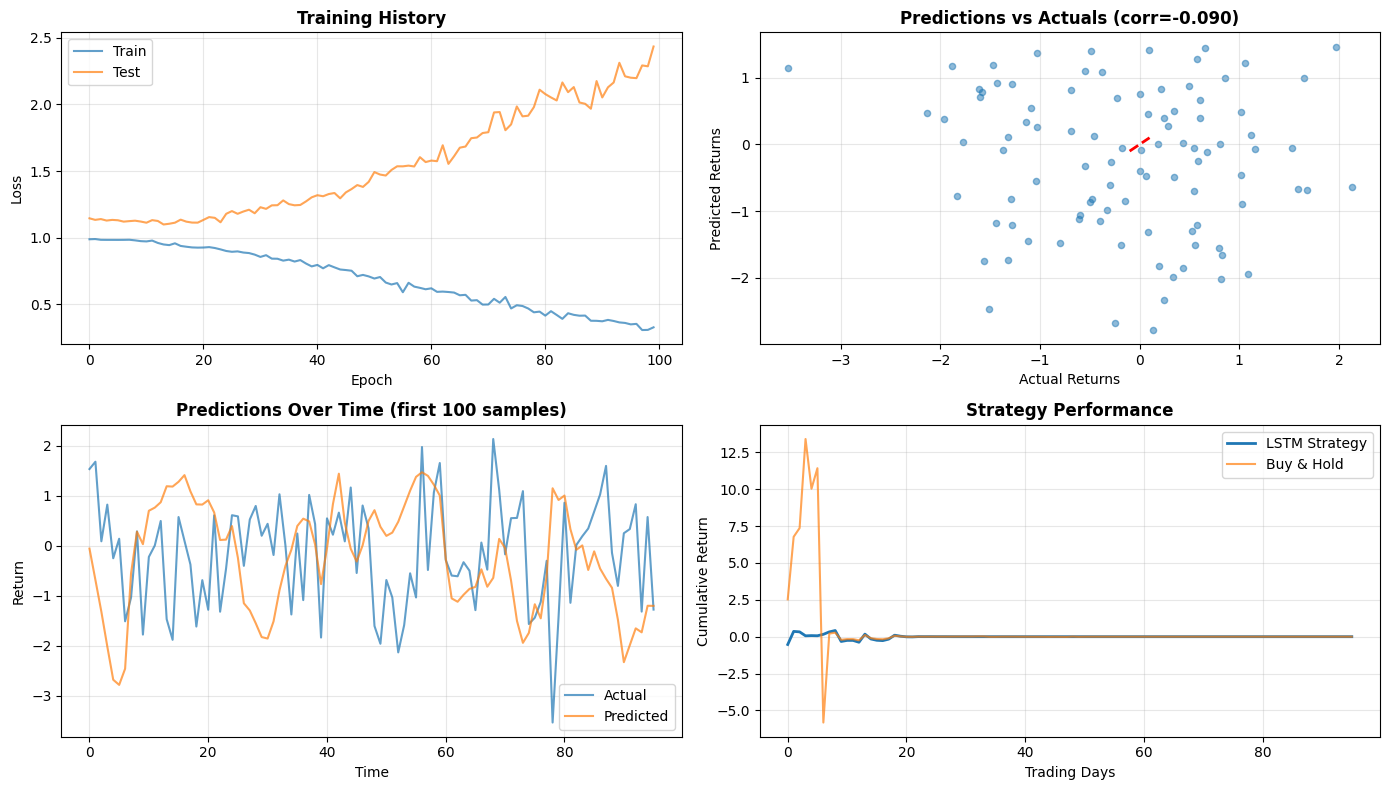


📈 Strategy Final Return: -100.0%
📈 Market Final Return:   -100.0%


In [7]:
# ============================================================
# EVALUATE LSTM PREDICTIONS
# ============================================================

print("LSTM PREDICTION EVALUATION")
print("="*60)

model.eval()
with torch.no_grad():
    predictions = model(X_test_t).numpy().flatten()
    actuals = y_test_t.numpy().flatten()

# Metrics
mse = np.mean((predictions - actuals)**2)
correlation = np.corrcoef(predictions, actuals)[0, 1]
direction_acc = np.mean(np.sign(predictions) == np.sign(actuals))

print(f"\nPrediction Metrics:")
print(f"  MSE:                {mse:.6f}")
print(f"  Correlation:        {correlation:.4f}")
print(f"  Direction Accuracy: {direction_acc*100:.1f}%")

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Training curves
axes[0, 0].plot(history['train_loss'], label='Train', alpha=0.7)
axes[0, 0].plot(history['test_loss'], label='Test', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training History', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Predictions vs Actuals
axes[0, 1].scatter(actuals, predictions, alpha=0.5, s=20)
axes[0, 1].plot([-0.1, 0.1], [-0.1, 0.1], 'r--', linewidth=2)
axes[0, 1].set_xlabel('Actual Returns')
axes[0, 1].set_ylabel('Predicted Returns')
axes[0, 1].set_title(f'Predictions vs Actuals (corr={correlation:.3f})', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Time series comparison
axes[1, 0].plot(actuals[:100], label='Actual', alpha=0.7)
axes[1, 0].plot(predictions[:100], label='Predicted', alpha=0.7)
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Return')
axes[1, 0].set_title('Predictions Over Time (first 100 samples)', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative strategy returns
strategy_returns = actuals * np.sign(predictions)
cumulative_strategy = np.cumprod(1 + strategy_returns)
cumulative_market = np.cumprod(1 + actuals)

axes[1, 1].plot(cumulative_strategy, label='LSTM Strategy', linewidth=2)
axes[1, 1].plot(cumulative_market, label='Buy & Hold', alpha=0.7)
axes[1, 1].set_xlabel('Trading Days')
axes[1, 1].set_ylabel('Cumulative Return')
axes[1, 1].set_title('Strategy Performance', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Strategy Final Return: {(cumulative_strategy[-1]-1)*100:.1f}%")
print(f"📈 Market Final Return:   {(cumulative_market[-1]-1)*100:.1f}%")

---

## Part 5: Gated Recurrent Unit (GRU)

### Simplified Gating

GRU combines forget and input gates into a single **update gate**:

$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$$  (Update gate)
$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$$  (Reset gate)
$$\tilde{h}_t = \tanh(W \cdot [r_t \odot h_{t-1}, x_t])$$  (Candidate)
$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$  (Update)

### GRU vs LSTM

| Aspect | LSTM | GRU |
|--------|------|-----|
| Gates | 3 (input, forget, output) | 2 (update, reset) |
| Parameters | More | ~25% fewer |
| Memory | Separate cell state | Merged into hidden |
| Training | Slower | Faster |
| Performance | Better on complex tasks | Comparable, sometimes better |

GRU vs LSTM COMPARISON

Parameter Comparison:
  LSTM: 53,057 parameters
  GRU:  40,321 parameters
  GRU saves: 24.0% parameters

Training GRU...

Final Test Loss - LSTM: 2.4349, GRU: 3.0127


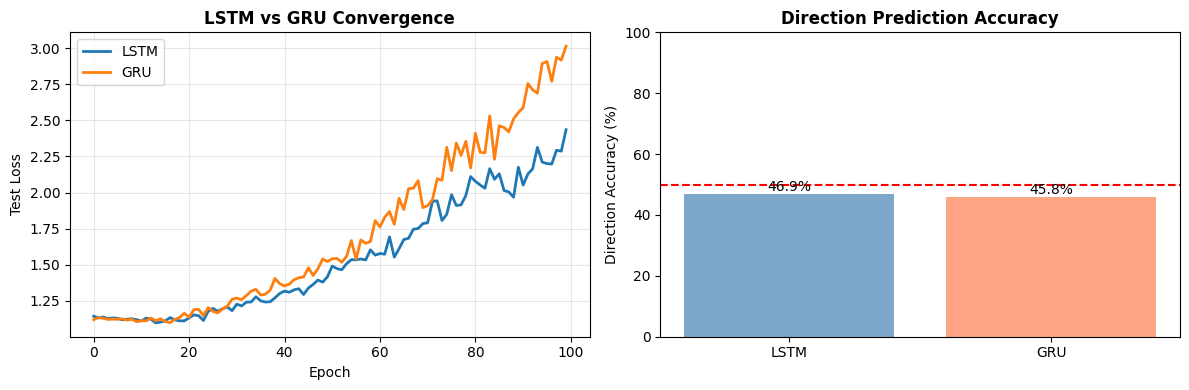


💡 KEY INSIGHT: GRU often performs similarly with fewer parameters


In [8]:
# ============================================================
# GRU IMPLEMENTATION AND COMPARISON
# ============================================================

print("GRU vs LSTM COMPARISON")
print("="*60)

class GRUPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, x):
        gru_out, h_n = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# Compare parameter counts
input_size, hidden_size = 3, 64
lstm_model = LSTMPredictor(input_size, hidden_size)
gru_model = GRUPredictor(input_size, hidden_size)

lstm_params = sum(p.numel() for p in lstm_model.parameters())
gru_params = sum(p.numel() for p in gru_model.parameters())

print(f"\nParameter Comparison:")
print(f"  LSTM: {lstm_params:,} parameters")
print(f"  GRU:  {gru_params:,} parameters")
print(f"  GRU saves: {(lstm_params - gru_params) / lstm_params * 100:.1f}% parameters")

# Train GRU
gru_model = GRUPredictor(input_size=3, hidden_size=64, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

gru_history = {'train_loss': [], 'test_loss': []}

print("\nTraining GRU...")
for epoch in range(100):
    gru_model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = gru_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gru_model.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
    
    gru_model.eval()
    with torch.no_grad():
        test_pred = gru_model(X_test_t)
        test_loss = criterion(test_pred, y_test_t).item()
    
    gru_history['train_loss'].append(epoch_loss / len(train_loader))
    gru_history['test_loss'].append(test_loss)

print(f"\nFinal Test Loss - LSTM: {history['test_loss'][-1]:.4f}, GRU: {gru_history['test_loss'][-1]:.4f}")

# Compare learning curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['test_loss'], label='LSTM', linewidth=2)
plt.plot(gru_history['test_loss'], label='GRU', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('LSTM vs GRU Convergence', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Direction accuracy comparison
gru_model.eval()
with torch.no_grad():
    lstm_preds = model(X_test_t).numpy().flatten()
    gru_preds = gru_model(X_test_t).numpy().flatten()

lstm_dir_acc = np.mean(np.sign(lstm_preds) == np.sign(actuals))
gru_dir_acc = np.mean(np.sign(gru_preds) == np.sign(actuals))

plt.subplot(1, 2, 2)
bars = plt.bar(['LSTM', 'GRU'], [lstm_dir_acc*100, gru_dir_acc*100], 
               color=['steelblue', 'coral'], alpha=0.7)
plt.axhline(50, color='red', linestyle='--', label='Random guess')
plt.ylabel('Direction Accuracy (%)')
plt.title('Direction Prediction Accuracy', fontweight='bold')
plt.ylim(0, 100)
for bar, acc in zip(bars, [lstm_dir_acc, gru_dir_acc]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc*100:.1f}%', ha='center')

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT: GRU often performs similarly with fewer parameters")

---

## Part 6: Bidirectional and Stacked Architectures

### Stacked (Deep) RNNs

Multiple layers of RNN cells:
```
Input → RNN Layer 1 → RNN Layer 2 → ... → Output
```

Each layer learns increasingly abstract temporal representations.

### Bidirectional RNNs

Process sequence in **both directions**:
```
Forward:  x₁ → x₂ → x₃ → ... → xₜ
Backward: x₁ ← x₂ ← x₃ ← ... ← xₜ
```

**⚠️ Finance Warning:** Bidirectional RNNs cause **look-ahead bias**!
- They use future information
- Only use for non-predictive tasks (e.g., anomaly detection with known outcomes)

STACKED LSTM ARCHITECTURES

Comparing LSTM depths...

  Depth 1: Loss=1.2269, Dir Acc=47.9%, Params=5,345
  Depth 2: Loss=1.3506, Dir Acc=46.9%, Params=13,793
  Depth 3: Loss=1.2944, Dir Acc=52.1%, Params=22,241
  Depth 4: Loss=1.2556, Dir Acc=40.6%, Params=30,689


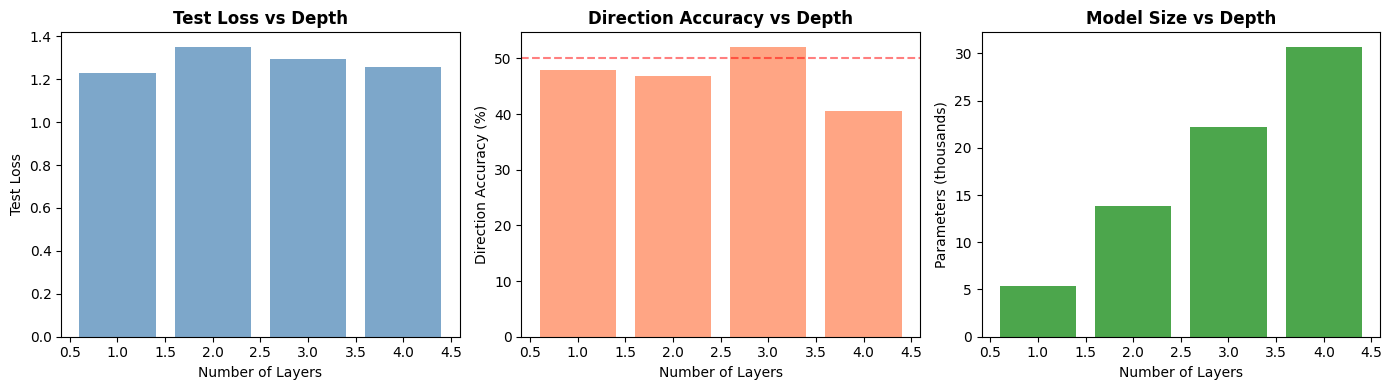


💡 INSIGHT: Deeper isn't always better - watch for overfitting!


In [9]:
# ============================================================
# STACKED LSTM ARCHITECTURE
# ============================================================

print("STACKED LSTM ARCHITECTURES")
print("="*60)

class StackedLSTM(nn.Module):
    """Multi-layer LSTM with residual connections."""
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super().__init__()
        
        self.num_layers = num_layers
        
        # Stacked LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False  # IMPORTANT: No look-ahead!
        )
        
        # Layer normalization for stability
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )
        
    def forward(self, x):
        # LSTM forward
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use last timestep output
        last_out = lstm_out[:, -1, :]
        
        # Layer normalization
        normalized = self.layer_norm(last_out)
        
        # Output
        return self.fc(normalized)

# Compare different depths
depths = [1, 2, 3, 4]
results = {}

print("\nComparing LSTM depths...\n")

for depth in depths:
    model = StackedLSTM(
        input_size=3, 
        hidden_size=32,  # Smaller for faster training
        num_layers=depth,
        output_size=1,
        dropout=0.2
    )
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Quick training (50 epochs)
    for epoch in range(50):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(X_batch), y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        preds = model(X_test_t).numpy().flatten()
        test_loss = criterion(model(X_test_t), y_test_t).item()
        dir_acc = np.mean(np.sign(preds) == np.sign(actuals))
    
    n_params = sum(p.numel() for p in model.parameters())
    results[depth] = {'loss': test_loss, 'dir_acc': dir_acc, 'params': n_params}
    
    print(f"  Depth {depth}: Loss={test_loss:.4f}, Dir Acc={dir_acc*100:.1f}%, Params={n_params:,}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].bar(depths, [r['loss'] for r in results.values()], color='steelblue', alpha=0.7)
axes[0].set_xlabel('Number of Layers')
axes[0].set_ylabel('Test Loss')
axes[0].set_title('Test Loss vs Depth', fontweight='bold')

axes[1].bar(depths, [r['dir_acc']*100 for r in results.values()], color='coral', alpha=0.7)
axes[1].axhline(50, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Number of Layers')
axes[1].set_ylabel('Direction Accuracy (%)')
axes[1].set_title('Direction Accuracy vs Depth', fontweight='bold')

axes[2].bar(depths, [r['params']/1000 for r in results.values()], color='green', alpha=0.7)
axes[2].set_xlabel('Number of Layers')
axes[2].set_ylabel('Parameters (thousands)')
axes[2].set_title('Model Size vs Depth', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 INSIGHT: Deeper isn't always better - watch for overfitting!")

---

## Part 7: Attention Mechanisms (Preview)

### The Attention Principle

Instead of compressing the entire sequence into one hidden state, **attention** allows the model to focus on relevant timesteps:

$$\alpha_t = \text{softmax}(\text{score}(h_t, s))$$
$$\text{context} = \sum_t \alpha_t \cdot h_t$$

Where:
- $\alpha_t$ = attention weight for timestep $t$
- $h_t$ = hidden state at timestep $t$
- $s$ = query (what we're looking for)

### Financial Applications

- **Earnings announcements:** Focus on recent data around events
- **Regime changes:** Attend to similar historical regimes
- **Technical patterns:** Focus on pattern-relevant timesteps

ATTENTION-BASED LSTM

Training Attention-LSTM...
  Epoch 25: Test Loss = 1.1724
  Epoch 50: Test Loss = 1.1713
  Epoch 75: Test Loss = 1.2941
  Epoch 100: Test Loss = 1.3102

Attention-LSTM Direction Accuracy: 52.1%


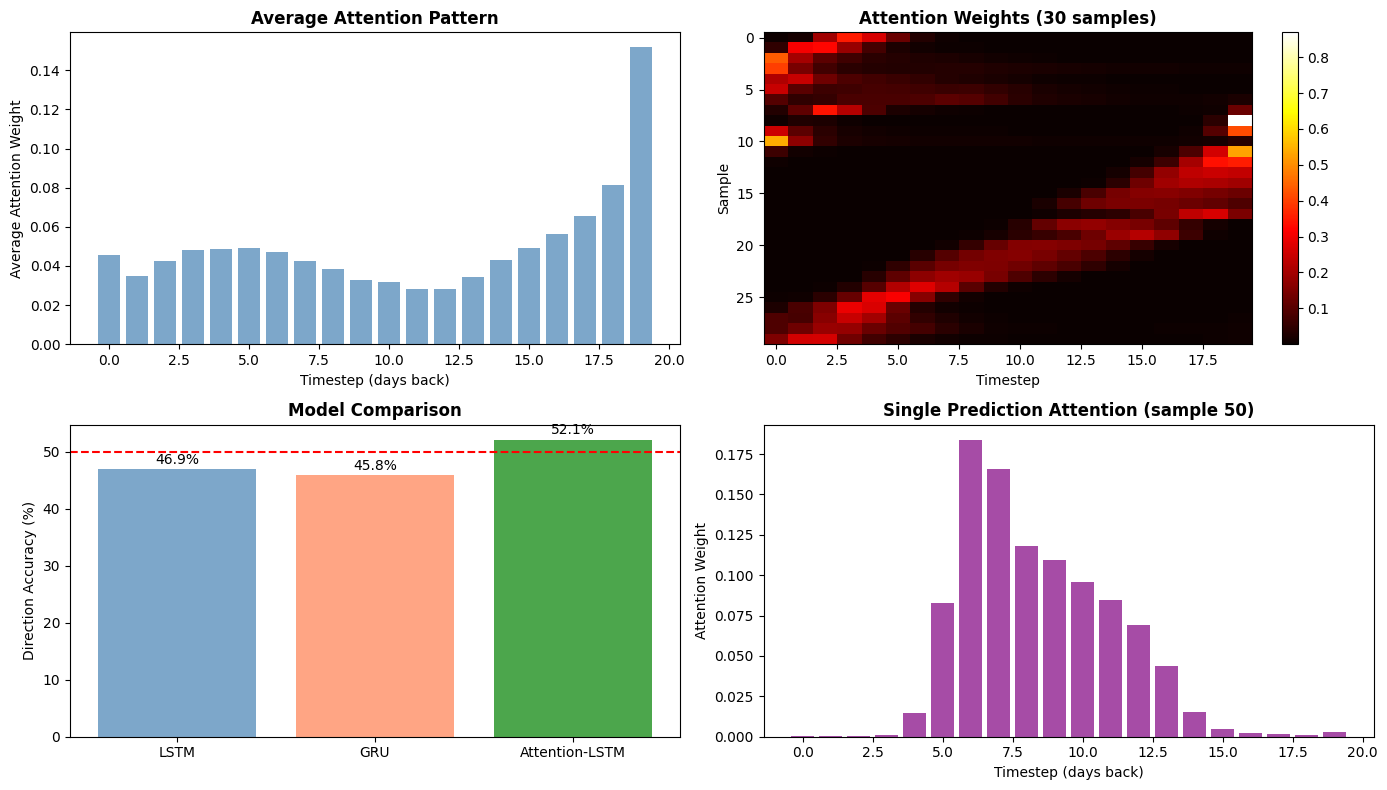


💡 KEY INSIGHT: Attention shows which past days the model focuses on
   - Recent days often get more weight (recency bias)
   - But attention can also capture distant patterns!


In [10]:
# ============================================================
# ATTENTION MECHANISM FOR SEQUENCE MODELS
# ============================================================

print("ATTENTION-BASED LSTM")
print("="*60)

class Attention(nn.Module):
    """Simple additive attention mechanism."""
    
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, lstm_outputs):
        """
        lstm_outputs: (batch, seq_len, hidden_size)
        Returns: context vector (batch, hidden_size), attention weights (batch, seq_len)
        """
        # Compute attention scores
        scores = self.attention(lstm_outputs)  # (batch, seq_len, 1)
        scores = scores.squeeze(-1)             # (batch, seq_len)
        
        # Softmax to get weights
        weights = torch.softmax(scores, dim=1)  # (batch, seq_len)
        
        # Weighted sum of hidden states
        context = torch.bmm(weights.unsqueeze(1), lstm_outputs)  # (batch, 1, hidden_size)
        context = context.squeeze(1)  # (batch, hidden_size)
        
        return context, weights


class AttentionLSTM(nn.Module):
    """LSTM with attention for financial prediction."""
    
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.attention = Attention(hidden_size)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, x, return_attention=False):
        # LSTM forward pass
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, hidden_size)
        
        # Attention
        context, weights = self.attention(lstm_out)
        
        # Output
        output = self.fc(context)
        
        if return_attention:
            return output, weights
        return output


# Train attention model
attn_model = AttentionLSTM(input_size=3, hidden_size=64, num_layers=2, dropout=0.2)
optimizer = optim.Adam(attn_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

print("\nTraining Attention-LSTM...")
attn_history = []

for epoch in range(100):
    attn_model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        loss = criterion(attn_model(X_batch), y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(attn_model.parameters(), 1.0)
        optimizer.step()
    
    if (epoch + 1) % 25 == 0:
        attn_model.eval()
        with torch.no_grad():
            test_loss = criterion(attn_model(X_test_t), y_test_t).item()
        print(f"  Epoch {epoch+1}: Test Loss = {test_loss:.4f}")

# Evaluate and visualize attention
attn_model.eval()
with torch.no_grad():
    preds, attention_weights = attn_model(X_test_t, return_attention=True)
    
attn_preds = preds.numpy().flatten()
attn_dir_acc = np.mean(np.sign(attn_preds) == np.sign(actuals))

print(f"\nAttention-LSTM Direction Accuracy: {attn_dir_acc*100:.1f}%")

# Visualize attention patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Average attention across test samples
avg_attention = attention_weights.mean(dim=0).numpy()

axes[0, 0].bar(range(len(avg_attention)), avg_attention, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Timestep (days back)')
axes[0, 0].set_ylabel('Average Attention Weight')
axes[0, 0].set_title('Average Attention Pattern', fontweight='bold')

# Attention heatmap for sample sequences
sample_weights = attention_weights[:30].numpy()
im = axes[0, 1].imshow(sample_weights, aspect='auto', cmap='hot')
axes[0, 1].set_xlabel('Timestep')
axes[0, 1].set_ylabel('Sample')
axes[0, 1].set_title('Attention Weights (30 samples)', fontweight='bold')
plt.colorbar(im, ax=axes[0, 1])

# Compare models
models = ['LSTM', 'GRU', 'Attention-LSTM']
accuracies = [lstm_dir_acc * 100, gru_dir_acc * 100, attn_dir_acc * 100]

axes[1, 0].bar(models, accuracies, color=['steelblue', 'coral', 'green'], alpha=0.7)
axes[1, 0].axhline(50, color='red', linestyle='--', label='Random')
axes[1, 0].set_ylabel('Direction Accuracy (%)')
axes[1, 0].set_title('Model Comparison', fontweight='bold')
for i, (m, acc) in enumerate(zip(models, accuracies)):
    axes[1, 0].text(i, acc + 1, f'{acc:.1f}%', ha='center')

# Attention on a specific prediction
idx = 50  # Sample index
sample_attn = attention_weights[idx].numpy()
axes[1, 1].bar(range(len(sample_attn)), sample_attn, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Timestep (days back)')
axes[1, 1].set_ylabel('Attention Weight')
axes[1, 1].set_title(f'Single Prediction Attention (sample {idx})', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHT: Attention shows which past days the model focuses on")
print("   - Recent days often get more weight (recency bias)")
print("   - But attention can also capture distant patterns!")

---

## Summary: Week 10 Key Concepts

### Architecture Comparison

| Model | Strengths | Weaknesses | Best For |
|-------|-----------|------------|----------|
| Vanilla RNN | Simple, fast | Vanishing gradients | Short sequences (<20) |
| LSTM | Long-term memory | More parameters | Complex patterns |
| GRU | Efficient, fewer params | Slightly less capacity | Most use cases |
| Attention | Interpretable, flexible | More computation | Variable focus |

### Production Best Practices

1. **Gradient Clipping:** Always use `clip_grad_norm_` (max 1.0-5.0)
2. **Layer Normalization:** Helps training stability
3. **Dropout:** Between LSTM layers, not in final layer
4. **Sequence Length:** Start with 20-50 timesteps
5. **Bidirectional:** AVOID for prediction (look-ahead bias!)

### Interview Questions

1. Why do vanilla RNNs fail on long sequences?
2. Explain the LSTM gates and their purpose
3. When would you use GRU over LSTM?
4. What is the danger of bidirectional RNNs in finance?
5. How does attention help with interpretability?

In [11]:
# ============================================================
# WEEK 10 SUMMARY
# ============================================================

print("""
╔══════════════════════════════════════════════════════════════════╗
║          WEEK 10 THEORY: SEQUENCE MODELS COMPLETE               ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Temporal dependencies in financial data                      ║
║  ✓ Vanilla RNN architecture and limitations                     ║
║  ✓ Vanishing gradient problem                                   ║
║  ✓ LSTM gates and cell state                                    ║
║  ✓ GRU simplified gating                                        ║
║  ✓ Stacked architectures                                        ║
║  ✓ Attention mechanisms                                         ║
║  ✓ Financial return prediction                                  ║
╚══════════════════════════════════════════════════════════════════╝

🎯 Next: Daily notebooks for hands-on practice!

   Day 1: RNN Fundamentals
   Day 2: Vanishing Gradients Deep Dive
   Day 3: LSTM Implementation
   Day 4: GRU Implementation
   Day 5: Bidirectional & Stacked
   Day 6: Attention Mechanisms
   Day 7: Complete Sequence Trading Model
""")


╔══════════════════════════════════════════════════════════════════╗
║          WEEK 10 THEORY: SEQUENCE MODELS COMPLETE               ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Temporal dependencies in financial data                      ║
║  ✓ Vanilla RNN architecture and limitations                     ║
║  ✓ Vanishing gradient problem                                   ║
║  ✓ LSTM gates and cell state                                    ║
║  ✓ GRU simplified gating                                        ║
║  ✓ Stacked architectures                                        ║
║  ✓ Attention mechanisms                                         ║
║  ✓ Financial return prediction                                  ║
╚══════════════════════════════════════════════════════════════════╝

🎯 Next: Daily notebooks for hands-on practice!

   Day 1: RNN Fundamentals
   Day 2: Vanishing Gradients Deep Dive
   Day 3: LSTM Implementation
   Day 4: GRU Implementation
   Da